<a href="https://colab.research.google.com/github/mikimizutani/food-recognition/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/My Drive/food-recognition/

Mounted at /content/drive/
/content/drive/My Drive/food-recognition


In [2]:
import sys
sys.path.append('/content/drive/My Drive/food-recognition/')
import classes

import os
import torch
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from classes import FoodDataset
from classes import FocalTverskyLoss
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
#from engine import train_one_epoch, evaluate
#import utils

In [ ]:
training_path = '/content/drive/My Drive/food-recognition/dataset/train/images.zip'

!ls
!cp "{training_path}" .
!unzip -n images.zip -d "/content/drive/My Drive/food-recognition/dataset/train/"


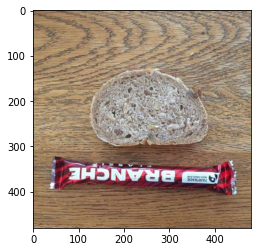

In [5]:
img = plt.imread("./dataset/train/images/021517.jpg")
plt.imshow(img)

In [4]:
def to_tensor():
    #Resizes images and boxes
    tensors = [torchvision.transforms.Resize((100,100)), torchvision.transforms.ToTensor()]
    return torchvision.transforms.Compose(tensors)


#Method to view image with the categories
def visualise_annotations(coco):
    # nms = set([cat['supercategory'] for cat in cats])
    catIds = coco.getCatIds()
    imgIds = coco.getImgIds()
    img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]
    image = mpimg.imread(os.path.join('./dataset/train/images/', str(img['file_name'])))
    plt.axis('off')
    plt.imshow(image)
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns)
    plt.show()


# def train(model, device, train_loader, optimizer):
#     model.train()
#     y_true = []
#     y_pred = []
#     for i in train_loader:
#
#         # LOADING THE DATA IN A BATCH
#         data, target = i
#
#         # MOVING THE TENSORS TO THE CONFIGURED DEVICE
#         data, target = data.to(device), target.to(device)
#
#         # FORWARD PASS
#         output = model(data.float())
#         loss = FocalTverskyLoss(output)
#         #loss = criterion(output, target.unsqueeze(1))
#
#         # BACKWARD AND OPTIMIZE
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#
#         # PREDICTIONS
#         pred = np.round(output.detach())
#         target = np.round(target.detach())
#         y_pred.extend(pred.tolist())
#         y_true.extend(target.tolist())
#
#         print("Accuracy on training set is",
#               accuracy_score(y_true, y_pred))


def val(model, device, test_loader):
    # model in eval mode skips Dropout etc
    model.eval()
    y_true = []
    y_pred = []

    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in test_loader:
            # LOAD THE DATA IN A BATCH
            data, target = i

            # moving the tensors to the configured device
            data, target = data.to(device), target.to(device)

            # the model on the data
            output = model(data.float())

            # PREDICTIONS
            pred = np.round(output)
            target = target.float()
            y_true.extend(target.tolist())
            y_pred.extend(pred.reshape(-1).tolist())

    print("Accuracy on test set is", accuracy_score(y_true, y_pred))
    print("***********************************************************")


def accuracy_score(true, pred):
    #TODO
    return


def get_model_instance_segmentation():
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 273  # 273 classes of food in the training database
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


if __name__ == '__main__':

    training_json = './dataset/train/annotations.json'
    training_path = './dataset/train/images/'
    #test_path = './dataset/val/images'
    #test_json = './dataset/val/annotations.json'

    #Use this block to see all the different food classes we have
    #coco = COCO(training_json)
    #cats = coco.loadCats(coco.getCatIds())
    #print(v: i + 1 for i, v in enumerate(sorted(self.coco.getCatIds())))
    #nms = [cat['name'] for cat in cats]
    #print('COCO categories: \n{}\n'.format(' '.join(nms)))
    #sys.exit()

    #visualise_annotations()
    num_epochs = 10

    training_data = FoodDataset(root=training_path, annotation=training_json, transforms=to_tensor())
    #validation_data = FoodDataset(root=test_path, annotation=test_json, transforms=to_tensor())
    training_dataloader = DataLoader(training_data, batch_size=2, shuffle=True, collate_fn=training_data.collate_fn)
    #validation_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True)
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # get the model using our helper function
    model = get_model_instance_segmentation()

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    for i in range(num_epochs):
        model.train()
        i = 0
        for imgs, annotations in training_dataloader:
            i += 1
            imgs = list(img.to(device) for img in imgs)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            loss_dict = model(imgs, annotations)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            print(f'Iteration: {i}/{len(training_dataloader)}, Loss: {losses}')

    print("That's it!")

loading annotations into memory...
Done (t=1.75s)
creating index...
index created!
{'boxes': tensor([[ 46.5000,  46.5000, 674.5000, 725.5000]]), 'labels': tensor([96]), 'image_id': tensor([40190]), 'area': tensor([178874.]), 'iscrowd': tensor([0])}
{'boxes': tensor([[ 48.3862,  48.3862, 383.6688, 387.5787]]), 'labels': tensor([24]), 'image_id': tensor([77617]), 'area': tensor([37357.]), 'iscrowd': tensor([0])}


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Iteration: 1/12060, Loss: 6.108433246612549
{'boxes': tensor([[ 80.5000,  80.5000, 300.0000, 410.5000]]), 'labels': tensor([206]), 'image_id': tensor([42532]), 'area': tensor([49311.]), 'iscrowd': tensor([0])}
{'boxes': tensor([[ 66.0000,  66.0000, 321.1000, 192.0000],
        [ 84.0000,  75.6000, 453.6000, 453.6000],
        [ 55.9000, 123.6000, 435.6000, 435.6000]]), 'labels': tensor([ 10, 259, 115]), 'image_id': tensor([16349]), 'area': tensor([15150., 71301., 26087.]), 'iscrowd': tensor([0, 0, 0])}
Iteration: 2/12060, Loss: 3.422244071960449
{'boxes': tensor([[ 69.5000,  72.5000, 301.5000, 303.5000]]), 'labels': tensor([70]), 'image_id': tensor([101460]), 'area': tensor([48320.]), 'iscrowd': tensor([0])}
{'boxes': tensor([[ 43.5000,  43.5000, 372.5000, 475.5000]]), 'labels': tensor([147]), 'image_id': tensor([14947]), 'area': tensor([80548.]), 'iscrowd': tensor([0])}
Iteration: 3/12060, Loss: 0.43945032358169556
{'boxes': tensor([[ 40.5000,  40.5000, 368.5000, 445.5000]]), 'labels'

KeyboardInterrupt: ignored